# Classification in Keras

## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import itertools
import urllib.request


import keras
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

Using TensorFlow backend.


## 2. Hyperparameters

In [2]:
MODE = 'test'
RUN_NAME = 'run01'
SAVE_DIR = 'models'
NUM_HIDDEN_UNITS = [70, 30]
EPOCHS = 500

In [3]:
# Create folder to save model
model_dir = os.path.join(SAVE_DIR, RUN_NAME)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## 3. Load the data

In [4]:
def download_data(url, filename):
    """
    Download the dataset from the url
    :param url: url of file to be downloaded
    :param filename: filname to be saved
    :return:
    """
    urllib.request.urlretrieve(url, filename)
    

def load_data(filename, class_col='class', rm_nan_by_axis=0):
    """
    Load the dataset from file and return X, y
    :param filename: name of xls file
    :param class_col: column name of class
    :param rm_nan_by_axis: remove empty values by axis row=0, column=1
    :return: X: features y:labels
    """
    xls_file = pd.read_excel(filename, index_col=0)
    # remove missing values by row: axis=0, column: axis=1
    xls_file = xls_file.dropna(axis=rm_nan_by_axis)

    X = xls_file[xls_file.columns[0:-4]].values
    y = xls_file[class_col].astype('category').cat.codes.values

    return X, y

In [5]:
# LOAD DATA
# Download the Mice Protein Expression dataset from uci
# https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls'
file_name = 'Data_Cortex_Nuclear.xls'
download_data(url, file_name)

# Load the dataset
X, y = load_data(file_name, rm_nan_by_axis=1)


num_samples, num_features = X.shape
num_classes = np.max(y) + 1

## 4. Preprocessing

In [6]:
# One-hot encode
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y_onehot = onehot_encoder.fit_transform(np.expand_dims(y, axis=1))

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=.3)

## 5. Create the model (i.e. Graph)

In [7]:
# BUILD MODEL
model = Sequential()
model.add(Dense(NUM_HIDDEN_UNITS[0], activation='relu', name='FC_1', input_shape=(num_features,)))
model.add(Dense(NUM_HIDDEN_UNITS[1], activation='relu', name='FC_2'))
model.add(Dense(num_classes, activation='softmax', name='output'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# CALLBACKS
# Early Stop
early_stop = EarlyStopping(monitor='val_loss', patience=20)

# TensorBoard
tensorboard = TensorBoard(log_dir=model_dir)

model.summary()

Instructions for updating:
Use the retry module or similar alternatives.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FC_1 (Dense)                 (None, 70)                2030      
_________________________________________________________________
FC_2 (Dense)                 (None, 30)                2130      
_________________________________________________________________
output (Dense)               (None, 8)                 248       
Total params: 4,408
Trainable params: 4,408
Non-trainable params: 0
_________________________________________________________________


## 6. Train

In [8]:
# run session and train
if MODE == 'train':
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=0.2,
              callbacks=[tensorboard, early_stop])

    model.save_weights(os.path.join(os.path.join(model_dir), 'wieghts.h5'))

## 7. Test

In [9]:
def plot_confusion_matrix(cm, classes=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    :param cm: confusion matrix
    :param classes: list of class names
    :param normalize: normalize to 0-1
    :param title: plot title
    :param cmap: colormap
    :return:
    """

    if classes is None:
        classes = ['class_{}'.format(i) for i in range(1, len(cm) + 1)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

324/324 [==============================] - 0s 95us/step
Testing set Loss: 0.10
Testing set Accuracy: 97.53%


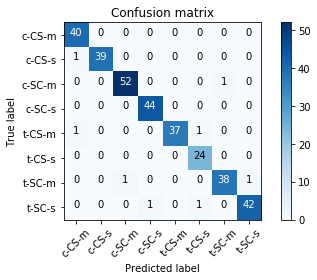

In [10]:
# run session and test
if MODE == 'test':
    model.load_weights(os.path.join(os.path.join(model_dir), 'wieghts.h5'))
    # test
    loss, acc = model.evaluate(X_test, y_test)
    print('Testing set Loss: {:.2f}'.format(loss))
    print('Testing set Accuracy: {:.2%}'.format(acc))
    # Predict
    y_pred = model.predict(X_test)
    classes = list(pd.read_excel(file_name, index_col=0)['class'].astype('category').cat.categories)
    cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    plot_confusion_matrix(cnf_matrix, classes=classes)